In [14]:
import numpy as np
import pandas as pd
import matplotlib
import math
from sklearn import model_selection, ensemble, metrics, linear_model, preprocessing, pipeline
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('dataset/undp_train.csv', na_values='nan')
test = pd.read_csv('dataset/undp_test.csv', na_values='nan')

In [21]:
# index_columns = ['Life expectancy Index',
#                  'Income Index',
#                  'Education Index',
#                  'Gender Development Index (GDI)',
#                  'Gender Inequality Index (GII)', ]

In [32]:
full = data.append(test, ignore_index=True)#.loc[:, ['year', 'country'] + index_columns + ['y']]

In [33]:
full

,year,country,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,...,"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII),y
0,1990,Afghanistan,0.467,50.3,2193.0,0.466,2.6,1.5,0.298,0.122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050220
1,1990,Albania,0.797,71.8,4415.0,0.572,11.6,7.8,0.644,0.584,...,NaN,NaN,NaN,NaN,NaN,2.3,0.1,NaN,NaN,0.082286
2,1990,Algeria,0.722,66.9,9989.0,0.695,9.6,3.6,0.578,0.385,...,NaN,NaN,NaN,NaN,NaN,9.0,0.1,NaN,NaN,0.064073
3,1990,Angola,0.389,45.3,4139.0,0.562,3.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,0.049559
4,1990,Argentina,0.794,71.6,10932.0,0.709,13.2,7.9,0.707,0.628,...,NaN,NaN,NaN,NaN,NaN,6.6,0.1,-0.4,NaN,0.074967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4750,2016,Yemen,0.709,66.1,1966.0,0.450,8.7,3.0,0.477,0.341,...,24.6,5.6,0.289,0.550,0.525,NaN,NaN,NaN,0.837,NaN
4751,2016,Vanuatu,0.770,70.0,2751.0,0.501,11.4,6.7,0.592,0.540,...,24.0,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4752,2016,Uruguay,0.885,77.5,19196.0,0.794,16.3,8.7,0.806,0.745,...,66.4,9.1,0.805,0.793,1.016,10.4,0.6,6.0,0.286,NaN
4753,2016,Viet Nam,0.849,75.2,5638.0,0.609,12.7,8.1,0.685,0.621,...,53.0,5.7,0.686,0.683,1.005,13.9,0.4,-5.8,0.323,NaN


In [34]:
# Data manipulation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS

def RMSE(x,y):
    return MSE(x,y)**0.5

# numeric_data_indices = list(range(len(data.columns)-1))
# numeric_data_indices.remove(1)
# numeric_data_indices.remove(0)
numeric_data_indices = list(range(2,len(full.columns)-1))

#categorical_data_indices = [0, 1]
categorical_data_indices = [0, 1]


# Pipeline
pipe = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
        ]))
    ]
)

# shortcut for scorer
nrmse = 'neg_root_mean_squared_error'

X = full.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

X = pipe.fit_transform(X)

X_train = X[:3865]
X_test = X[3865:]

In [35]:
import xgboost as xgb
XGB = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1500,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=3,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.5,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=0.3,
    reg_alpha=0,
    reg_lambda=0.001,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
    seed=None,
    missing=None,
    importance_type='gain')
XGB.fit(X_train, y_train)

print(MSE(y_train, XGB.predict(X_train))**0.5)

0.0005468701211214334


In [36]:
cvs = -CVS(XGB, X_train,y_train, scoring=nrmse, cv=5)
print(cvs.mean(), 'CV score 5-fold of XGB on train')

0.013950781571014554 CV score 5-fold of XGB on train


In [37]:
cvs

array([0.01332485, 0.00516161, 0.00750657, 0.00694955, 0.03681133])

In [40]:
y_pred = XGB.predict(X_test)

# Part 2

In [56]:
raw_test = pd.read_csv('dataset/test.csv')

In [57]:
# alpha is the coefficient before each E_i in calculating
# the likely index increase \Delta y_i multiplied by 1000
def P(y):
    return -np.log(y + 0.01) + 3
def alpha(y):
    return P(y)**2/1000
p2slice = raw_test.iloc[:, 2:3]
p2slice['y pred'] = pd.Series(y_pred)

In [58]:
a = test.iloc[-5:]['Life expectancy Index'] + 0.153
a

885    0.862
886    0.923
887    1.038
888    1.002
889    0.773
Name: Life expectancy Index, dtype: float64

In [59]:
p2slice.iloc[-5:, 0] = a

In [61]:
p2slice['alpha'] = pd.Series([alpha(x) for x in p2slice['y pred']])

In [63]:
p2slice[p2slice['existence expectancy index'] < 0.7]

,existence expectancy index,y pred,alpha
0,0.456086,0.041525,0.035589
1,0.529835,0.039138,0.036158
2,0.560976,0.038931,0.036209
3,0.565910,0.039335,0.036110
4,0.588274,0.020409,0.042159
...,...,...,...
61,0.686832,0.043693,0.035099
62,0.688025,0.027848,0.039365
63,0.692317,0.036923,0.036715
64,0.698337,0.027029,0.039640


In [64]:
#indices of 50 largest by alpha points that have EEI < 0.7
k = p2slice[p2slice['existence expectancy index']<0.7]['alpha'].nlargest(50).index.sort_values()
print (k)

#indices of 450 largest by alpha points after dropping the necessary 50 with EEI <0.7
a = p2slice.drop(k)['alpha'].nlargest(450).index.sort_values()
print(a)

k = np.array(k)
a = np.array(a)
ka = np.concatenate([k,a])
print(ka)

Int64Index([ 1,  2,  3,  4,  5,  6, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 25, 26, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 45, 46, 47,
            48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65],
           dtype='int64')
Int64Index([  0,   7,   8,   9,  12,  24,  28,  30,  32,  33,
            ...
            775, 780, 784, 790, 816, 838, 844, 885, 886, 889],
           dtype='int64', length=450)
[  1   2   3   4   5   6  10  11  13  14  15  16  17  18  19  20  21  22
  23  25  26  27  29  31  34  35  37  38  39  40  41  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  60  62  63  64  65   0   7   8   9
  12  24  28  30  32  33  36  42  43  44  59  61  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 13

In [65]:
answer = pd.DataFrame(data={'index': raw_test.index,
                  'pred': y_pred,
                  'opt_pred': 0})
for i in ka:
    answer.iloc[i, 2] = 100

In [67]:
answer['opt_pred'].sum()

50000

In [68]:
answer[p2slice['existence expectancy index']<0.7]['opt_pred'].sum()

6600

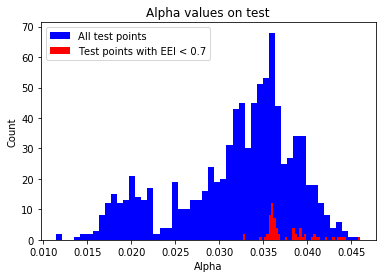

In [69]:
plt.hist(p2slice['alpha'], label='All test points', color='b', bins=50)
plt.hist(p2slice.iloc[:66, -1],
         label ='Test points with EEI < 0.7', color='r', bins=50)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Count')
plt.title('Alpha values on test')
plt.show()

In [70]:
answer = answer.set_index(['index'])

In [72]:
answer.to_csv('answer2.csv')